# PreTraining Undamaged Model - Selecting Background Images

Objective: train a YOLO model on pre-event undamaged buildings (residential, commercial) to a sufficient level of accuracy. This model will be trained on an initial manually annotated dataset.

In [1]:
import os
HOME = os.getcwd()
print(f'HOME directory path: \'{HOME}\'')

HOME directory path: '/content'


#### Initialization of Google Collab environment

In [2]:
requirements_packages = """
rasterio==1.4.2
ultralytics>=8.3
labelme2yolo==0.2.5
roboflow==1.1.48
"""

# Specify the file name
file_name = "requirements.txt"

# Write the text to the file
with open(file_name, 'w') as file:
    file.write(requirements_packages)

print(f"File '{file_name}' has been created with the text.")

# Installing required packages quietly without showing the details
!pip install -r {HOME}/requirements.txt --quiet

File 'requirements.txt' has been created with the text.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.5 MB/s eta 0:00:00


# Connecting to RoboFlow database

In [3]:
import roboflow
roboflow.login(force=True) # Login into roboflow

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


## Importing packages

In [4]:
import torch

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
from IPython.display import Image

# Progress bar
from tqdm import tqdm

import numpy as np

# Others
import os
import shutil
import zipfile

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Define project details

In [5]:
# Downloading dataset from Roboflow platform (Notice: after execution data will be deleted from google colab)
roboflow_project_name = 'stormdamagechallenge'
dataset_name = 'storm-damage'
dataset_title = 'Storm-Damage'
dataset_id = 'goe2a'
dataset_version = 19 # Cleaned Commercial Buildings
model_name = 'yolo'
model_version = '11' # 'v8' or '11'
model_variant = 'n' # parameter required for model training phase

# Connect to roboflow dataset
rf = roboflow.Roboflow()
project = rf.workspace(roboflow_project_name).project(dataset_name + '-' + dataset_id)
dataset = project.version(dataset_version).download(model_name + model_version)

loading Roboflow workspace...
loading Roboflow project...

Version export complete for yolo11 format



Extracting Dataset Version Zip to Storm-Damage-19 in yolo11:: 100%|██████████| 608/608 [00:00<00:00, 8024.37it/s]


### Check Ultralytics connection

In [6]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
ultralytics.checks()

Ultralytics 8.3.216 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.7/112.6 GB disk)


In [8]:
!nvidia-smi

Thu Oct 16 06:27:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Loading YOLO model for Training

In [8]:
model = YOLO("/content/best.pt")  # load a custom trained model
model.info()

YOLO11n summary: 181 layers, 2,590,230 parameters, 0 gradients, 6.4 GFLOPs


(181, 2590230, 0, 6.4416768)

In [14]:
# # Loading the model
# model = YOLO(f'../models/{model_name + model_version}/{model_name + model_version + model_variant}.pt')
# # Display model information (optional)
# model.info()

YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(181, 2624080, 0, 6.614336)

In [9]:
yaml_file = f'{HOME}/{dataset_title}-{dataset_version}/data.yaml'
yaml_file

'/content/Storm-Damage-19/data.yaml'

## Pre-Training Model

In [10]:
# Define model training parameters
batch = 75 # set as an integer (e.g., batch=16), auto mode for 60% GPU memory utilization (batch=-1), or auto mode with specified utilization fraction (batch=0.70)
device = 0 # 0: GPU | 'cpu': cpu | 'mps': apple silicon mps
epochs = 30
patience = 20
imgsz = 640 # TODO: assess the importance of image size 640x640 by-design of Yolo models, image size role
plots = True
project = 'exploratory_phase' # parent directory name
name_train = f'{model_name + model_version + model_variant}_training_dataset_v{dataset_version}' # run directory name

In [17]:
# # Empty cash of CUDA, to free-up the GPU memory after training. Required before restarting a new training session
# import torch
# torch.cuda.empty_cache()

In [18]:
# Train the model - v19
result_model_training = model.train(
                                    data=yaml_file,
                                    batch = batch,
                                    device = device,
                                    epochs = epochs,
                                    patience = patience,
                                    imgsz = imgsz,
                                    optimizer = 'AdamW',
                                    augment = False, # (bool) apply image augmentation to prediction sources
                                    lr0 = 1e-4, # 5e-5, 1e-5 previously
                                    auto_augment = None, # (str) auto augmentation policy for classification (randaugment, autoaugment, augmix)
                                    momentum = 0.937,
                                    plots = plots,
                                    project = project,
                                    name = name_train
                                    )

Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=75, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Storm-Damage-19/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../models/yolo11/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_training_dataset_v192, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=

In [21]:
# Evaluate the model on the test dataset - v19
metrics_val = model.val(
    data=yaml_file,  # Path to the data.yaml file
    split="val",                   # Specify the test split
    batch = batch,                  # Batch size for evaluation
    save_json = True,
    plots=True,
    imgsz=640,                      # Image size
    conf=0.001,                      # Confidence threshold
    iou=0.7,                        # IoU threshold for NMS
    device=device,                     # Use GPU (e.g., "0" for the first GPU)
)

Ultralytics 8.3.216 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1533.3±564.9 MB/s, size: 64.2 KB)
val: Scanning /content/Storm-Damage-19/valid/labels.cache... 68 images, 18 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 68/68 77.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.2it/s 4.2s
                   all         68        990      0.704      0.693      0.711      0.386
undamagedcommercialbuilding         28         93      0.625      0.646      0.636        0.4
undamagedresidentialbuilding         36        897      0.782       0.74      0.787      0.373
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Saving /content/runs/detect/val4/predictions.json...
Results saved to /content/runs/detect/val4


In [22]:
metrics_val.to_df()

Class,Images,Instances,Box-P,Box-R,Box-F1,mAP50,mAP50-95
str,i64,i64,f64,f64,f64,f64,f64
"""undamagedcommercialbuilding""",28,93,0.62515,0.64557,0.6352,0.63586,0.40005
"""undamagedresidentialbuilding""",36,897,0.78207,0.74011,0.76051,0.78691,0.37262


In [28]:
metrics_val.box.a

AttributeError: 'Metric' object has no attribute 'a'. See valid attributes below.

    Class for computing evaluation metrics for Ultralytics YOLO models.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50: AP at IoU threshold of 0.5 for all classes.
        ap: AP at IoU thresholds from 0.5 to 0.95 for all classes.
        mp: Mean precision of all classes.
        mr: Mean recall of all classes.
        map50: Mean AP at IoU threshold of 0.5 for all classes.
        map75: Mean AP at IoU threshold of 0.75 for all classes.
        map: Mean AP at IoU thresholds from 0.5 to 0.95 for all classes.
        mean_results: Mean of results, returns mp, mr, map50, map.
        class_result: Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps: mAP of each class.
        fitness: Model fitness as a weighted combination of metrics.
        update: Update metric attributes with new evaluation results.
        curves: Provides a list of curves for accessing specific metrics like precision, recall, F1, etc.
        curves_results: Provide a list of results for accessing specific metrics like precision, recall, F1, etc.
    

In [35]:
len(metrics_val.box.curves_results[1])

4

In [65]:
metrics_val.box.curves_results[2][3]

'Precision'

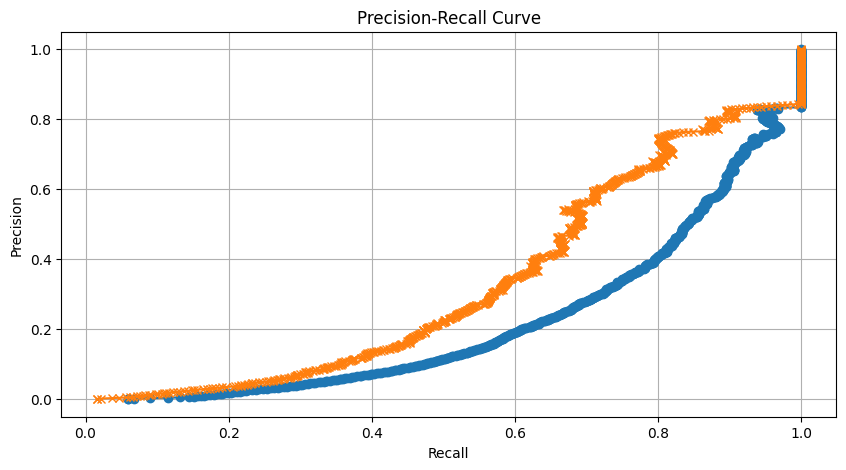

In [66]:
precision_res = metrics_val.box.curves_results[2][1][1]
precision_com = metrics_val.box.curves_results[2][1][0]
recall = metrics_val.box.curves_results[2][0]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(precision_res,recall, marker='o')
plt.plot(precision_com,recall, marker='x')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

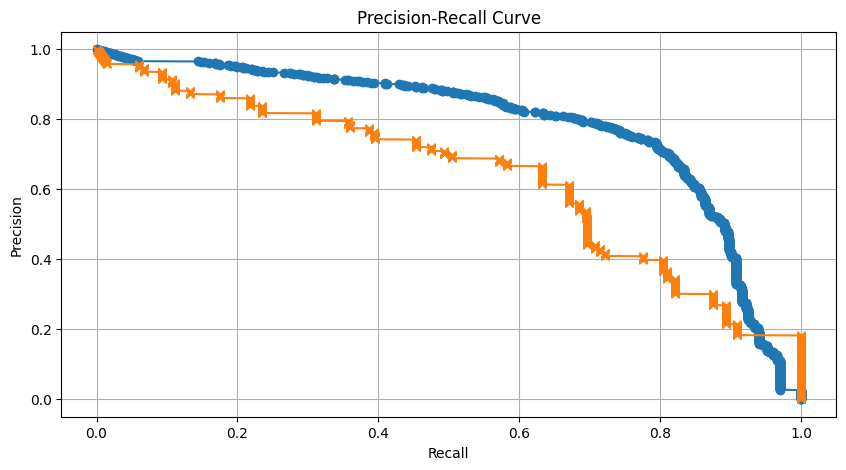

In [58]:
precision_res = metrics_val.box.curves_results[0][1][1]
precision_com = metrics_val.box.curves_results[0][1][0]
recall = metrics_val.box.curves_results[0][0]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(precision_res,recall, marker='o')
plt.plot(precision_com,recall, marker='x')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [39]:
metrics_val.curves[0], len(metrics_val.curves_results[0])

('Precision-Recall(B)', 4)

In [56]:
metrics_val.curves_results[0][0]

array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,    0.049049,     0.05005,    0.051051,    0.052052,    0.053053,    0.054054,    0.055055,    0.056056,    0.057057,    0.058058,    0.059059,     0.06006,    0.061061,    0.062062,    0.063063,    0.064064,    0.065065,    0.066066,    0.067067,    0.068068,    0.069069,     0.07007,    0.071071,
          0.072072,    0.073073,    0.07407

In [1]:
# Plotting PR curve
# len(metrics_val.curves_results)
plt.plot(metrics_val.curves_results[0][0], metrics_val.curves_results[0][1][0])
plt.show()

NameError: name 'plt' is not defined

In [73]:
metrics_val.results_dict

{'metrics/precision(B)': 0.0,
 'metrics/recall(B)': 0.0,
 'metrics/mAP50(B)': 0.0,
 'metrics/mAP50-95(B)': 0.0,
 'fitness': 0.0}

In [77]:
import pandas as pd
data = pd.read_csv('/content/exploratory_phase/yolo11n_training_dataset_v19/results.csv')

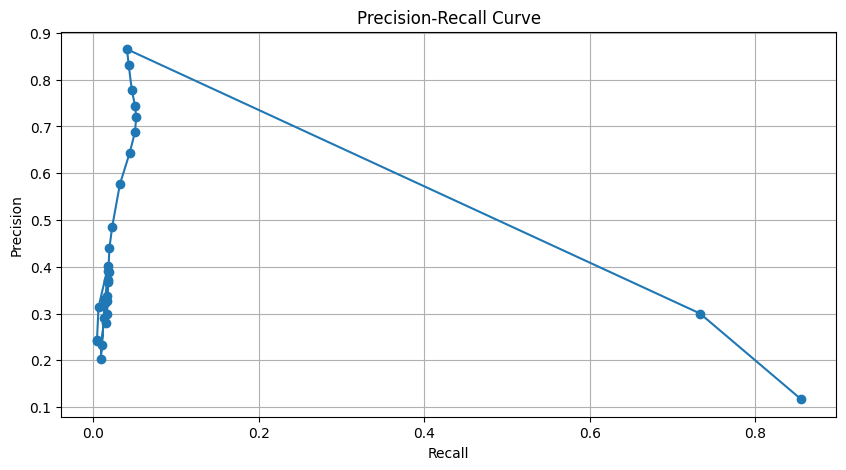

In [82]:
precision = data['metrics/precision(B)']
recall = data['metrics/recall(B)']

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(precision,recall, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [ ]:
# Extract results from files
# dataset_version,size_ds,size_train,size_val,size_test,mAP_50_val,mAP_50_val_uc,mAP_50_val_ur,mAP_50_test,mAP_50_test_uc,mAP_50_test_ur,P_val,P_val_uc,P_val_ur,P_test,P_test_uc,P_test_ur,R_val,R_val_uc,R_val_ur,R_test,R_test_uc,R_test_ur
# 19,298,209,68,21,0.675,0.582,0.769,0.619,0.608,0.629,0.635,0.574,0.696,0.579,0.457,0.7,0.679,0.57,0.788,0.628,0.706,0.551
# 22,400,280,60,60,
# 23,498,349,89,60,

In [ ]:
# Train the model - v22
result_model_training = model.train(
                                    data=yaml_file,
                                    batch = batch,
                                    device = device,
                                    epochs = epochs,
                                    patience = patience,
                                    imgsz = imgsz,
                                    optimizer = 'AdamW',
                                    augment = False, # (bool) apply image augmentation to prediction sources
                                    lr0 = 5e-5, # 1e-5 previously
                                    auto_augment = None, # (str) auto augmentation policy for classification (randaugment, autoaugment, augmix)
                                    momentum = 0.937,
                                    plots = plots,
                                    project = project,
                                    name = name_train
                                    )

Ultralytics 8.3.209 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=75, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Storm-Damage-22/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=5e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../models/yolo11/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_training_dataset_v222, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=2

In [ ]:
# Evaluate the model on the test dataset - v22
metrics_test_v22 = model.val(
    data=yaml_file,  # Path to the data.yaml file
    split="test",                   # Specify the test split
    batch = batch,                  # Batch size for evaluation
    imgsz=640,                      # Image size
    conf=0.5,                      # Confidence threshold
    iou=0.7,                        # IoU threshold for NMS
    device=device,                     # Use GPU (e.g., "0" for the first GPU)
)

Ultralytics 8.3.209 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 22.1±10.6 MB/s, size: 62.9 KB)
val: Scanning /content/Storm-Damage-22/test/labels... 60 images, 7 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 60/60 303.9it/s 0.2s
val: New cache created: /content/Storm-Damage-22/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.2it/s 4.3s
                   all         60       1198       0.71      0.669      0.704      0.465
undamagedcommercialbuilding         18         63      0.625      0.619      0.602       0.42
undamagedresidentialbuilding         47       1135      0.795      0.718      0.807       0.51
Speed: 0.2ms preprocess, 5.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to /content/runs/detect/val3


In [ ]:
# Train the model - v23
result_model_training_v23 = model.train(
                                    data=yaml_file,
                                    batch = batch,
                                    device = device,
                                    epochs = epochs,
                                    patience = patience,
                                    imgsz = imgsz,
                                    optimizer = 'AdamW',
                                    augment = False, # (bool) apply image augmentation to prediction sources
                                    lr0 = 5e-5, # 1e-5 previously
                                    auto_augment = None, # (str) auto augmentation policy for classification (randaugment, autoaugment, augmix)
                                    momentum = 0.937,
                                    plots = plots,
                                    project = project,
                                    name = name_train
                                    )

Ultralytics 8.3.209 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=75, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Storm-Damage-23/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=5e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../models/yolo11/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_training_dataset_v23, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20

In [ ]:
# Evaluate the model on the test dataset - v23
metrics_test_v23 = model.val(
    data=yaml_file,  # Path to the data.yaml file
    split="test",                   # Specify the test split
    batch = batch,                  # Batch size for evaluation
    imgsz=640,                      # Image size
    conf=0.5,                      # Confidence threshold
    iou=0.7,                        # IoU threshold for NMS
    device=device,                     # Use GPU (e.g., "0" for the first GPU)
)

Ultralytics 8.3.209 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1499.5±559.9 MB/s, size: 58.1 KB)
val: Scanning /content/Storm-Damage-23/test/labels.cache... 60 images, 7 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 60/60 9.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.5it/s 2.1s
                   all         60       1198      0.745      0.587      0.683       0.49
undamagedcommercialbuilding         18         63      0.646      0.492      0.593      0.466
undamagedresidentialbuilding         47       1135      0.845      0.683      0.774      0.514
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to /content/runs/detect/val5


In [ ]:
sult_model_training = model.train(
                                    data=yaml_file,
                                    batch = batch,
                                    device = device,
                                    epochs = epochs,
                                    patience = patience,
                                    imgsz = imgsz,
                                    optimizer = 'AdamW',
                                    augment = False, # (bool) apply image augmentation to prediction sources
                                    lr0 = 1e-5,
                                    auto_augment = None, # (str) auto augmentation policy for classification (randaugment, autoaugment, augmix)
                                    momentum = 0.937,
                                    plots = plots,
                                    project = project,
                                    name = name_train
                                    )

In [ ]:
# Evaluate the model on the test dataset
metrics_test = model.val(
    data=yaml_file,  # Path to the data.yaml file
    split="test",                   # Specify the test split
    batch = batch,                  # Batch size for evaluation
    imgsz=640,                      # Image size
    conf=0.25,                      # Confidence threshold
    iou=0.7,                        # IoU threshold for NMS
    device=device,                     # Use GPU (e.g., "0" for the first GPU)
)

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1651.5±390.5 MB/s, size: 60.9 KB)
val: Scanning /content/Storm-Damage-21/test/labels.cache... 31 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 31/31 35.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.0it/s 1.0s
                   all         31        736      0.675      0.739      0.692       0.48
undamagedcommercialbuilding          7         22      0.525      0.727      0.556      0.408
undamagedresidentialbuilding         25        714      0.826      0.751      0.828      0.552
Speed: 0.2ms preprocess, 5.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/exploratory_phase/yolo11n_training_dataset_v2110


In [ ]:
# Evaluate the model on the test dataset
metrics_validation = model.val(
    data=yaml_file,  # Path to the data.yaml file
    split="val",                   # Specify the test split
    batch=batch,                  # Batch size for evaluation
    imgsz=640,                      # Image size
    conf=0.25,                      # Confidence threshold
    iou=0.7,                        # IoU threshold for NMS
    device=device,                     # Use GPU (e.g., "0" for the first GPU)
)

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1476.5±325.0 MB/s, size: 61.2 KB)
val: Scanning /content/Storm-Damage-21/valid/labels.cache... 86 images, 18 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 86/86 91.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 0.5it/s 3.7s
                   all         86       1318       0.74      0.753      0.781      0.511
undamagedcommercialbuilding         35        117      0.685      0.701      0.722       0.51
undamagedresidentialbuilding         51       1201      0.795      0.805      0.841      0.512
Speed: 12.8ms preprocess, 5.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/exploratory_phase/yolo11n_training_dataset_v219


In [ ]:
# Best model evaluation
model_best_v20 = YOLO("best_model_v20/best.pt")  # load a custom trained model
model_best_v20.info()

YOLO11n summary: 181 layers, 2,590,230 parameters, 0 gradients, 6.4 GFLOPs


(181, 2590230, 0, 6.4416768)

In [ ]:
metrics_model_v20 = model_best_v20.val(
    data=yaml_file,  # Path to the data.yaml file
    split="test",                   # Specify the test split
    batch = batch,                  # Batch size for evaluation
    imgsz=640,                      # Image size
    conf=0.25,                      # Confidence threshold
    iou=0.7,                        # IoU threshold for NMS
    device=device,                     # Use GPU (e.g., "0" for the first GPU)
)

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1485.2±707.6 MB/s, size: 61.3 KB)
val: Scanning /content/Storm-Damage-20/test/labels.cache... 21 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 21/21 23.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.1it/s 0.9s
                   all         21        313      0.521      0.633      0.537      0.269
undamagedcommercialbuilding          5         17      0.349      0.706       0.45      0.258
undamagedresidentialbuilding         16        296      0.693      0.561      0.624       0.28
Speed: 0.2ms preprocess, 5.7ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /content/runs/detect/val5


In [ ]:
metrics_model_v20_test = metrics_model_v20

In [ ]:
metrics_model_v20_val = model_best_v20.val(
    data=yaml_file,  # Path to the data.yaml file
    split="val",                   # Specify the test split
    batch = batch,                  # Batch size for evaluation
    imgsz=640,                      # Image size
    conf=0.25,                      # Confidence threshold
    iou=0.7,                        # IoU threshold for NMS
    device=device,                     # Use GPU (e.g., "0" for the first GPU)
)

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1739.5±437.8 MB/s, size: 52.7 KB)
val: Scanning /content/Storm-Damage-20/valid/labels.cache... 68 images, 18 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 68/68 107.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.2it/s 6.4s
                   all         68        990      0.704      0.693      0.713      0.414
undamagedcommercialbuilding         28         93      0.625      0.646      0.645      0.428
undamagedresidentialbuilding         36        897      0.782       0.74      0.781        0.4
Speed: 0.3ms preprocess, 5.5ms inference, 0.0ms loss, 15.7ms postprocess per image
Results saved to /content/runs/detect/val6


In [ ]:
metrics_model_v20_test.box.map50

np.float64(0.5370464752390851)

In [ ]:
metrics_model_v20_val.box.map50

np.float64(0.7132242930093187)

In [ ]:
from google.colab import files
import os

dir_to_zip = '/content/exploratory_phase/yolo11n_training_dataset_v219' #@param {type: "string"}
output_filename = 'train_dv21_sizen_Best_p781.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Define search space
search_space = {
    "lr0": (1e-7, 1e-5),
}

model.tune(
    data=yaml_file,
    epochs=10,
    iterations=10,
    optimizer="AdamW",
    space=search_space,
    plots=True,
    save=True,
    val=True,
)

Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune3'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 1e-05}
Saved runs/detect/tune3/tune_scatter_plots.png
Saved runs/detect/tune3/tune_fitness.png

Tuner: 1/10 iterations complete ✅ (160.16s)
Tuner: Results saved to runs/detect/tune3
Tuner: Best fitness=0.32673 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.54884, 'metrics/recall(B)': 0.6011, 'metrics/mAP50(B)': 0.58511, 'metrics/mAP50-95(B)': 0.29802, 'val/box_loss': 1.66166, 'val/cls_loss': 1.49102, 'val/dfl_loss': 1.32241, 'fitness': 0.32673}
Tuner: Best fitness model is runs/detect/train3
Tuner: Best fitness hyperparameters are printed below.

Printing 'runs/detect/tune3/best_hyperparameters.yaml'

lr0: 1.0e-05

Tuner: Starting iteration 2/10 with hyperparameters: {'lr0': 1e-05}
Saved runs/detect/tune3/tune_scatter_plots.png
Saved ru

KeyboardInterrupt: 

In [ ]:
from google.colab import files
files.download("/content/exploratory_phase/yolo11n_training_dataset_v14")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
result_model_training

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bc49e6eb860>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
results_test = model.val(data=yaml_file, split='test')

Ultralytics 8.3.184 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2361.5±632.7 MB/s, size: 61.8 KB)


val: Scanning /content/Storm-Damage-19/test/labels.cache... 21 images, 4 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


                   all         21        313      0.559       0.66      0.639        0.3
undamagedcommercialbuilding          5         17      0.444      0.706      0.655       0.33
undamagedresidentialbuilding         16        296      0.675      0.615      0.623       0.27
Speed: 0.2ms preprocess, 5.5ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to exploratory_phase/yolo11n_training_dataset_v194


In [ ]:
results_test

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78d9a57fa4e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
results_test.box.map50

np.float64(0.6391766169993673)

## Use trained model for inference

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_gdrive_images = '/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/'

In [ ]:
images_inference = [path_gdrive_images+filename for filename in os.listdir(path_gdrive_images)]
images_inference.sort()
images_inference

['/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_0_18.jpg',
 '/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_0_24.jpg',
 '/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_0_30.jpg',
 '/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_0_4.jpg',
 '/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_0_5.jpg',
 '/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_10_102.jpg',
 '/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_10_103.jpg',
 '/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_10_18.jpg',
 '/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_10_19.jpg',
 '/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_10_24.jpg',
 '/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_10_25.jpg',
 '/content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_10_30.jpg

In [ ]:
inference_results = model.predict(images_inference, save=False, imgsz=640, conf=0.5)


0: 640x640 39 undamagedresidentialbuildings, 3.4ms
1: 640x640 34 undamagedresidentialbuildings, 3.4ms
2: 640x640 (no detections), 3.4ms
3: 640x640 (no detections), 3.4ms
4: 640x640 (no detections), 3.4ms
5: 640x640 14 undamagedresidentialbuildings, 3.4ms
6: 640x640 (no detections), 3.4ms
7: 640x640 58 undamagedresidentialbuildings, 3.4ms
8: 640x640 1 undamagedcommercialbuilding, 41 undamagedresidentialbuildings, 3.4ms
9: 640x640 51 undamagedresidentialbuildings, 3.4ms
10: 640x640 3 undamagedcommercialbuildings, 32 undamagedresidentialbuildings, 3.4ms
11: 640x640 42 undamagedresidentialbuildings, 3.4ms
12: 640x640 20 undamagedresidentialbuildings, 3.4ms
13: 640x640 (no detections), 3.4ms
14: 640x640 (no detections), 3.4ms
15: 640x640 (no detections), 3.4ms
16: 640x640 (no detections), 3.4ms
17: 640x640 4 undamagedresidentialbuildings, 3.4ms
18: 640x640 (no detections), 3.4ms
19: 640x640 36 undamagedresidentialbuildings, 3.4ms
20: 640x640 4 undamagedresidentialbuildings, 3.4ms
21: 640x6

In [ ]:
type(inference_results[0])

ultralytics.engine.results.Results

In [ ]:
len(inference_results[4])

17

In [ ]:
inference_results[1].names

{0: 'undamagedcommercialbuilding', 1: 'undamagedresidentialbuilding'}

In [ ]:
inference_results[1]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'undamagedcommercialbuilding', 1: 'undamagedresidentialbuilding'}
obb: None
orig_img: array([[[ 56,  91,  47],
        [ 55,  90,  46],
        [ 55,  90,  46],
        ...,
        [ 36,  54,  31],
        [ 37,  55,  32],
        [ 36,  54,  31]],

       [[ 56,  91,  47],
        [ 56,  91,  47],
        [ 57,  92,  48],
        ...,
        [ 28,  46,  23],
        [ 35,  53,  30],
        [ 39,  57,  34]],

       [[ 54,  89,  45],
        [ 55,  90,  46],
        [ 56,  91,  47],
        ...,
        [ 29,  47,  24],
        [ 36,  55,  30],
        [ 40,  59,  34]],

       ...,

       [[216, 220, 225],
        [215, 219, 224],
        [215, 219, 224],
        ...,
        [ 94,  96,  97],
        [ 92,  94,  95],
        [ 92,  94,  95]],

       [[216, 220, 225],
        [216, 220, 225],
        [216, 220, 225],
        ...,
       

In [ ]:
inference_results[1].boxes.cls.cpu().numpy()

array([          1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,
                 1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,
                 1,           1,           1,           1,           1,           1,           1], dtype=float32)

In [ ]:
inference_results[1].boxes.conf.cpu().numpy()

array([    0.86175,     0.78157,     0.57962,     0.49385,     0.42382,     0.29368,     0.23214,     0.21685,     0.20087], dtype=float32)

In [ ]:
inference_results[1].path

'/content/images_inference/Pre_Event_tile_0_51.jpg'

In [ ]:
classes_ids =  {class_name: class_id for class_id, class_name in inference_results[1].names.items()}
classes_ids

{'undamagedcommercialbuilding': 0, 'undamagedresidentialbuilding': 1}

In [ ]:
inference_results[1].names

{0: 'undamagedcommercialbuilding', 1: 'undamagedresidentialbuilding'}

In [ ]:
from collections import defaultdict

# images_containing_commercial_buildings : dict[str] = defaultdict(str)

images_containing_commercial_buildings: dict[str, dict[str, str]] = {}

temp = []

for i, inference_result in enumerate(inference_results):
  classes_ids =  {class_name: class_id for class_id, class_name in inference_result.names.items()}
  image_objects_detected = inference_result.boxes.cls.cpu().numpy()
  class_commercial = classes_ids['undamagedcommercialbuilding']
  class_residential = classes_ids['undamagedresidentialbuilding']
  if not class_commercial in image_objects_detected and not class_residential in image_objects_detected:
    print(f'i: {i} - {inference_result.path}')
    temp.append(inference_result.path)


i: 2 - /content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_0_30.jpg
i: 3 - /content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_0_4.jpg
i: 4 - /content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_0_5.jpg
i: 6 - /content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_10_103.jpg
i: 13 - /content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_10_6.jpg
i: 14 - /content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_10_7.jpg
i: 15 - /content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_11_106.jpg
i: 16 - /content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_11_107.jpg
i: 18 - /content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_11_113.jpg
i: 26 - /content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_12_4.jpg
i: 27 - /content/drive/MyDrive/Images_Pre_Event/pre_JPEG_Tiles/Pre_Event_tile_12_5.jpg
i: 34 - /content/drive/MyDrive/Images_Pre

In [ ]:
import os
import shutil

In [ ]:
def copy_files(files_paths: list[str], source_dir: str, destination_dir: str):

  # Create a source directory
  os.makedirs(name=destination_dir, exist_ok=True)


In [ ]:
# Writing a scrypt that iterates over all the images in the list of results in model predict
# Iterate over all files, select the paths of results images which contain commercial buildings with high enough confidence > 0.8
# store all these paths in a list the use it to select these files in a folder on the local machine
# then upload them to roboflow for manual annotation and extension of the dataset

In [ ]:
os.makedirs(name='image_paths_commercial_buildings', exist_ok=True)

In [ ]:
dest_path = 'image_paths_commercial_buildings'

In [ ]:
shutil.copy2('/content/images_inference/Pre_Event_tile_1_68.jpg', dest_path)

'image_paths_commercial_buildings/Pre_Event_tile_1_68.jpg'

In [ ]:
len(inference_results)

232